# Preprocessing: feature scaling

## Previous steps

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

housing = pd.read_csv("./data/housing.csv")
train_set, test_set = train_test_split(housing, test_size=0.2,
    stratify=pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5]),
    random_state=42
    )

X_train = train_set.drop("median_house_value", axis=1)
y_train = train_set["median_house_value"].copy()
X_train_num = X_train.select_dtypes(include=[np.number])

## Scaling, normalization and standardization

Most Machine Learning algorithms don't work well when features have very different scales. For example, many classifiers calculate the distance between two points using Euclidean distance. If one of the features has much larger values than the others, the distance will be dominated by this feature. For example, in our dataset, the range of 'median_income' goes from 0 to 15, while the range of 'total_rooms' goes from 6 to 39,320.

To avoid this, it's common to scale the features.

The terminology can be confusing at this point. In general, **normalization** refers to changing the scale of data to fit a specific range, while **standardization** refers to changing the distribution of data to have a mean of 0 and a standard deviation of 1. In both cases, they are linear transformations that don't change the shape of the data distribution. In statistics there's usually a clear distinction between both terms, but in deep learning and computer vision, the terminology can be less consistent and **it's common to use "normalization" to refer to standardization**.

In [2]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,16512.0,-119.575635,2.001828,-124.3500,-121.80000,-118.51000,-118.010000,-114.3100
latitude,16512.0,35.639314,2.137963,32.5400,33.94000,34.26000,37.720000,41.9500
housing_median_age,16512.0,28.653404,12.574819,1.0000,18.00000,29.00000,37.000000,52.0000
total_rooms,16512.0,2622.539789,2138.417080,6.0000,1443.00000,2119.00000,3141.000000,39320.0000
total_bedrooms,16354.0,534.914639,412.665649,2.0000,295.00000,433.00000,644.000000,6210.0000
population,16512.0,1419.687379,1115.663036,3.0000,784.00000,1164.00000,1719.000000,35682.0000
households,16512.0,497.011810,375.696156,2.0000,279.00000,408.00000,602.000000,5358.0000
median_income,16512.0,3.875884,1.904931,0.4999,2.56695,3.54155,4.745325,15.0001


## MinMaxScaler

The most common normalization is **min-max normalization** or **min-max scaling**. **Min-max normalization** is the simplest: values are scaled and shifted so that they end up in the range between a minimum value and a maximum value. Normally it will be between 0 and 1, although they can be others (neural networks usually work better with *inputs* with mean 0, so sometimes the range -1 to 1 is used). Scikit-Learn provides a `MinMaxScaler` class for this.

$$ X_{norm} = \frac{X - X_{min}}{X_{max} - X_{min}} $$

In [3]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(X_train_num)

Min-Max normalization is very sensitive to *outliers*, since a single very large value can completely change the scale of the data. In a situation where all data is between 20 and 30 but a single value of 100 appears, the maximum becomes 100, shifting all other values to a very low range. In general, Min-Max normalization should only be used if we're sure that the *outliers* are not errors. Techniques such as capping or Winsorizing can be applied beforehand to limit the impact of extreme values (see [Outliers and capped values](e2e020_eda.ipynb#Outliers-and-capped-values)).

## StandardScaler

On the other hand, **Z-score standardization** (***standard score***) is different: first it subtracts the mean (so it becomes 0), and then divides by the **standard deviation** so that the resulting distribution has standard deviation 1. Unlike min-max scaling, standardization doesn't limit values to a specific range, but this also has the advantage of being much less sensitive to outliers. Scikit-Learn provides a `StandardScaler` class for this.

$$ X_{std} = \frac{X - \mu}{\sigma} $$

In [4]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(X_train_num)

Many ML models work better by standardizing input *features* and it's a common and systematic practice in most cases (except for tree-based models). Scaling the *target* is less common, but can be useful in some cases, particularly for gradient-based models (such as neural networks) or distance-based models (such as KNN or SVM regressions).

For example, we could apply StandardScaler again to the labels:

In [5]:
target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(y_train.to_frame()) # convert the target to a dataframe (fit_transform expects 2D)
print(type(y_train)) # Since it's a single column, the labels were previously stored in a Series object
scaled_labels

<class 'pandas.core.series.Series'>


array([[-1.16601465],
       [ 0.62745084],
       [-1.07439665],
       ...,
       [-0.5756836 ],
       [ 0.44162188],
       [-1.2472608 ]], shape=(16512, 1))

## Scaling target variables and subsequent inversion

If we transform the target variable in any way, our model's output will also return transformed predictions. If we want the predictions to be on the original scale, we'll need to invert the transformation. Many of Scikit-Learn's transformers have an `inverse_transform()` method, which makes it easy to calculate the inverse of their transformations.

> **Note:** Not all transformations are invertible. For example:
> - **Numerical scalers** (`StandardScaler`, `MinMaxScaler`): Always invertible—they store the parameters needed to reverse the transformation.
> - **`OneHotEncoder`**: Technically invertible via `inverse_transform()`, but information loss occurs if the original categories aren't known.
> - **`OrdinalEncoder`**: Invertible if categories are preserved.
> - **Information-lossy transformations**: Some transformations like quantile-based discretization or heavy rounding cannot be perfectly inverted.

To give a simplified example, we're going to train a **simple linear regression with the most correlated predictor** (median_income) and the labels we just scaled. Then we'll test its predictions with the test set and undo the transformation.

In [6]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train[["median_income"]], scaled_labels) # train the model with scaled independent variables

some_new_data = X_train[["median_income"]].iloc[:5]  # for simplicity, we simulate new inputs to predict by taking 5 rows (we haven't preprocessed the test set)

scaled_predictions = model.predict(some_new_data)
target_scaler.inverse_transform(scaled_predictions) # Undo the transformation to get predictions on the original scale

array([[135958.75805364],
       [309735.008975  ],
       [165232.3998617 ],
       [138162.41971241],
       [232903.1766333 ]])

This process can be simplified using the `TransformedTargetRegressor` class from Scikit-Learn, which allows training a model with transformed labels and undoing the transformation automatically.

In [7]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(regressor = LinearRegression(),
                                   transformer = StandardScaler()) # dependent variable transformer
model.fit(X_train[["median_income"]], y_train)
model.predict(some_new_data)

array([135958.75805364, 309735.008975  , 165232.3998617 , 138162.41971241,
       232903.1766333 ])

## Heavy-tailed distributions

Heavy-tailed distributions are characterized by a long tail towards one side, which means they contain some very large values that can disproportionately influence the model. The logarithmic transformation compresses this long tail, reducing the range of values and making the distribution more normal. This helps decrease the impact of outliers, which leads to more stable and robust models. After applying the logarithm, scaling is still important to bring the transformed data to a common range, ensuring that all features contribute equally to the learning process and further improving model performance.

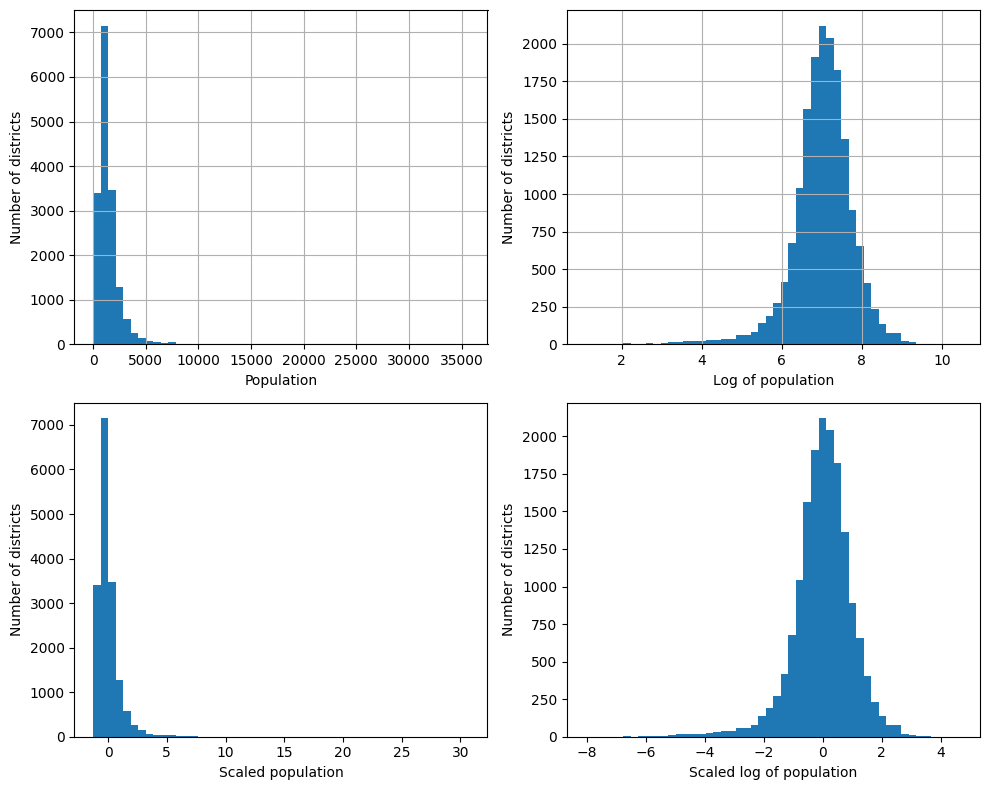

In [8]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Original distribution
X_train["population"].hist(ax=axs[0, 0], bins=50)
axs[0, 0].set_xlabel("Population")
axs[0, 0].set_ylabel("Number of districts")

# Log transformation
log_pop = X_train["population"].apply(np.log)
log_pop.hist(ax=axs[0, 1], bins=50)
axs[0, 1].set_xlabel("Log of population")
axs[0, 1].set_ylabel("Number of districts")

# Standard scaling
scaler = StandardScaler()
scaled_pop = scaler.fit_transform(X_train["population"].values.reshape(-1, 1)).flatten()
axs[1, 0].hist(scaled_pop, bins=50)
axs[1, 0].set_xlabel("Scaled population")
axs[1, 0].set_ylabel("Number of districts")

# Log transformation + standard scaling
scaled_log_pop = scaler.fit_transform(log_pop.values.reshape(-1, 1)).flatten()
axs[1, 1].hist(scaled_log_pop, bins=50)
axs[1, 1].set_xlabel("Scaled log of population")
axs[1, 1].set_ylabel("Number of districts")

plt.tight_layout()
plt.show()